<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




**Comparative** Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location & Import Dependencies

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [ ]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import cv2
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
import pandas as pd
from IPython.display import HTML, display
import time
import gc
import random
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers


"""
Seeding to achieving consistent results across training and inference sessions.
"""

# Seed value
seed_value = 42

# Set python built-in pseudo-random generator
random.seed(seed_value)

# Set numpy pseudo-random generator
np.random.seed(seed_value)

# Set tensorflow pseudo-random generator
tf.random.set_seed(seed_value)

# Set PYTHONHASHSEED environment variable
os.environ['PYTHONHASHSEED'] = str(seed_value)


base_directory = '/content/drive/MyDrive/VideoAnomalyDetection/'
base_dataset_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'
saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'
train_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train_2.txt'


# Read Dataset

In [ ]:
def read_video_paths_from_file(file_path, base_dataset_dir):
    full_file_path = os.path.join(base_dataset_dir, file_path)

    with open(full_file_path, 'r') as file:
        # Concatenate base_dataset_dir with each path read from the file
        paths = [os.path.join(base_dataset_dir, line.strip()) for line in file]

    return paths

def filter_video_paths(paths, filter_keyword):
    return [path for path in paths if filter_keyword.lower() in path.lower()]


def filter_video_paths_by_anomaly_type(paths, anomaly_type):
    """Filter video paths based on a specific anomaly type."""
    return [path for path in paths if anomaly_type.lower() in path.lower()]
import os
import cv2

def can_read_file(filepath):
    """
    This function checks the existence of the file and optionally its extension.

    Parameters:
    - filepath: Path to the video file.

    Returns:
    - bool: True if the file exists and has a video file extension; False otherwise.
    """
    # List of common video file extensions for basic filtering.
    video_extensions = ['.avi', '.mp4', '.mov', '.mkv']

    if not os.path.exists(filepath) or not os.path.isfile(filepath):
        return False

    # Check if the file extension is in the list of video extensions.
    file_extension = os.path.splitext(filepath)[1].lower()
    if file_extension not in video_extensions:
        return False

    return True


# Read video paths from the file
video_paths = read_video_paths_from_file(train_file_path,base_dataset_dir)

# Use "Shooting" and "Normal" to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')
"""
for anomaly_path in anomaly_videos:
    print(anomaly_path)

for normal_path in normal_videos:
    print(normal_path)
"""


'\nfor anomaly_path in anomaly_videos:\n    print(anomaly_path)\n\nfor normal_path in normal_videos:\n    print(normal_path)\n'

# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [ ]:
def preprocess_and_segment_video(video_input, resize_shape=(224, 224), segment_length=32):
    frames = []
    is_video_file = isinstance(video_input, str)

    if is_video_file:
        if not os.path.exists(video_input):
            print(f"File does not exist: {video_input}")
            return
        if not can_read_file(video_input):
            print(f"Cannot read file: {video_input}")
            return

        try:
            cap = cv2.VideoCapture(video_input)
            if not cap.isOpened():
                raise IOError(f"OpenCV could not open video file for an unknown reason: {video_input}")
        except Exception as e:
            print(f"Error: {e}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

        cap.release()
    elif isinstance(video_input, (list, np.ndarray)):
        # Additional check for non-empty list/array
        if len(video_input) == 0:
            print("The list/array of frames is empty.")
            return

        frames = video_input
    else:
        raise ValueError("Invalid type for video_input. Must be a file path or list/array of frames.")

    # Segmenting the frames
    for i in range(0, len(frames), segment_length):
        segment_frames = frames[i:i+segment_length]
        if len(segment_frames) < segment_length:
            segment_frames.extend([np.zeros(resize_shape + (3,), dtype=np.float32) for _ in range(segment_length - len(segment_frames))])
        yield np.stack(segment_frames, axis=0)


"""
all_videos = anomaly_videos + normal_videos
for video_path in all_videos:
    for segment in preprocess_and_segment_video(video_path):
        print(f"Segment shape: {segment.shape} : {video_path}")
"""


'\nall_videos = anomaly_videos + normal_videos\nfor video_path in all_videos:\n    for segment in preprocess_and_segment_video(video_path):\n        print(f"Segment shape: {segment.shape} : {video_path}")\n'

#Video Processing Utilities

In [ ]:
def list_video_files(directory, extension='mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
     # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory does not exist - {directory}")
        return []  # Return an empty list instead of None

    # Check if the directory can be accessed (read permissions)
    if not os.access(directory, os.R_OK):
        print(f"Error: Directory cannot be read, check permissions - {directory}")
        return []  # Return an empty list instead of None

    # Perform a recursive search for video files
    pattern = os.path.join(directory, '**', f'*.{extension}')
    _video_files = glob.glob(pattern, recursive=True)
    return _video_files


def shuffle_together(video_paths, labels):
    """
    Shuffle two lists in unison.

    Parameters:
    - video_paths: The first list to shuffle.
    - label: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled video_paths and label.
    """
    if len(video_paths) != len(labels):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    video_paths_shuffled, label_shuffled = shuffle(video_paths, labels)
    return video_paths_shuffled, label_shuffled

def get_total_frames(video_path):
    """
    Returns the total number of frames in a video.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - The total number of frames as an integer.
    """
    # Initialize the video capture object with the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return 0  # Indicates that the video could not be opened

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return total_frames

def segments_per_video(video_path, segment_length=32):
    total_frames = get_total_frames(video_path)  # This function needs to return the total frame count
    segments = 0
    if total_frames != 0:
          segments = total_frames // segment_length
          if total_frames % segment_length != 0:
              segments += 1  # Account for the last, potentially shorter, segment
    print("{} frames, {} segments for {}".format(total_frames,segments,video_path))
    return segments
"""
video_path = anomaly_videos[0]
total_segments = segments_per_video(video_path, segment_length=32)
print(f"Total segments: {total_segments}")
"""

'\nvideo_path = anomaly_videos[0]\ntotal_segments = segments_per_video(video_path, segment_length=32)\nprint(f"Total segments: {total_segments}")\n'

#Generate Features and Labels

In [ ]:
def create_dataset_from_videos(video_paths, labels, resize_shape=(224, 224), segment_length=32):
    """
    Creates a TensorFlow dataset of video segments with corresponding labels.

    Args:
        video_paths (list of str): Paths to video files.
        labels (list of int): Labels for each video file.
        resize_shape (tuple): The target shape for resizing frames.
        segment_length (int): Number of frames per video segment.

    Returns:
        tf.data.Dataset: A dataset of video segments and labels.
    """
    def generator():
        count = 0;
        for video_path, label in zip(video_paths, labels):
            count = count + 1;
            video_gen = preprocess_and_segment_video(video_path, resize_shape, segment_length)
            print("Video files count: {} processing: {}".format(count, video_path))
            # Iterate over the generator and yield its items
            for segment in video_gen:  # Iterate over items yielded by video_gen
                yield segment, label
            """
            if features is not None:
                # Yield features and label if processing was successful
                yield features, label
            else:
                print(f"Skipping video {video_path}, unable to process.")
            """
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )



# Fine-Tune Pretrained Video Swin Transformer Model for Video Classification

In [ ]:
def build_finetune_model():
    """
    Fine-tune pretrained model.

    Parameters:
        saved_model_path (str): Path to the saved Video Swin Transformer model.

    Returns:
        model (keras.Model): Fine-tuned model for shooting classification.
    """
    # Load the pretrained Video Swin model
    video_swin = load_model(saved_model_path, compile=False)

    # Fine-tuning configuration: set the last N layers to be trainable
    # N=1, fine-tune the last layer of the pretrained model
    """
    N=1
    for layer in video_swin.layers[:-N]:
        layer.trainable = False
    for layer in video_swin.layers[-N:]:
        layer.trainable = True
    """
    # Set the entire Video Swin model to non-trainable
    video_swin.trainable = False

    # Downstream model for binary classification
    model = Sequential([
        video_swin,
        # Assume video_swin's output shape is compatible with the Dense layer's input
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization again if needed
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    return model


#Train the Fine-Tuned Model for Shooting Classification

In [ ]:
# Define the base directory to save checkpoints
model_chkpt_filename = f"training_1/vad_{int(time.time())}.ckpt"
checkpoint_path = os.path.join(base_directory, model_chkpt_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create the base directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Callbacks configuration
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'),  # Save the best model based on val_loss
    EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=10),  # Stop training when `val_loss` is no longer improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5),  # Reduce learning rate when `val_loss` plateaus
    TensorBoard(
        log_dir=os.path.join(base_directory, 'logs'),  # Path to save log files for TensorBoard in Google Drive
        histogram_freq=1,  # Record activation histograms every 1 epoch
        embeddings_freq=1)  # Record embedding data every 1 epoch
]


# Define a custom callback for clearing the session and collecting garbage
class ClearSessionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

# Assume `callbacks_list` is already defined. Add the new callback to it.
callbacks_list.append(ClearSessionCallback())

## Multiple Instance Learning Loss

In [ ]:
def mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01, margin=5.0):
    """
    MIL ranking loss with sparsity and smoothness constraints.

    Args:
    - sparsity_weight: Weight for the sparsity term.
    - smoothness_weight: Weight for the smoothness term.
    - margin: Margin for the ranking loss.

    Returns:
    - A loss function that takes (y_true, y_pred) as inputs.
    """

    def loss(y_true, y_pred):
        # Separate the anomaly scores into positive and negative samples based on the labels.
        positive_scores = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        negative_scores = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        # Calculate the highest scores for positive and negative samples.
        highest_positive_score = tf.reduce_max(positive_scores)
        highest_negative_score = tf.reduce_max(negative_scores)

        # Calculate ranking loss.
        ranking_loss = tf.maximum(0.0, margin - highest_positive_score + highest_negative_score)

        # Calculate sparsity loss (L1 norm of the predictions).
        sparsity_loss = tf.reduce_sum(tf.abs(y_pred))

        # Calculate smoothness loss (squared difference between adjacent anomaly scores).
        diffs = y_pred[:, 1:] - y_pred[:, :-1]
        smoothness_loss = tf.reduce_sum(tf.square(diffs))

        # Combine the losses using the weights and loss components.
        total_loss = ranking_loss + (sparsity_weight * sparsity_loss) + (smoothness_weight * smoothness_loss)

        return total_loss

    return loss

In [ ]:
#anomaly_videos, normal_videos = list_video_files(anomaly_dir), list_video_files(normal_dir)
print("\nanomaly_videos", len(anomaly_videos))
print("\nnormal_videos", len(normal_videos))

video_paths = anomaly_videos + normal_videos
labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)
print("\nvideo paths {} and labels {}".format(video_paths,labels))
video_paths, labels = shuffle_together(video_paths, labels)
print("\nShuffled: video paths {} and labels {}".format(video_paths,labels))
dataset = create_dataset_from_videos(video_paths, labels)


cache_data_filename = f"./cache.tf-data_{int(time.time())}"
dataset = dataset.cache(cache_data_filename)

"""
for features, label in dataset.take(3):
    print("\nFeatures shape:", features.numpy().shape)
"""

# calculate the total video segments i.e training dataset size
total_segments_actual = sum(segments_per_video(video_path, segment_length=32) for video_path in video_paths)
print(f"\nTotal segments across all videos: {total_segments_actual}")

"""
total_segments_actual = sum(1 for _ in dataset)
print("\nTotal segments actually in dataset:", total_segments_actual)
"""
# Calculate split sizes
train_data_size = int(total_segments_actual * 0.8)
print("\nTraining size split into :", train_data_size)


val_data_size = total_segments_actual - train_data_size

print("\nValidation size split into :", val_data_size)


# Ensure dataset is shuffled (use actual total size if known for better shuffling, uses more memory)
dataset = dataset.shuffle(buffer_size=(total_segments_actual//2),reshuffle_each_iteration=True)



"""
train_segments_split = sum(1 for _ in train_dataset)
print("\nTraining segments split:", train_segments_split)

val_segments_split = sum(1 for _ in val_dataset)
print("\nValidation segments split:", val_segments_split)

for features, label in train_dataset.take(1):
    print("Train: Features shape:", features.numpy().shape)
    print("Train: Label shape:", label.numpy())
    print("\nTrain: Labels:", label)

for features, label in val_dataset.take(1):
    print("\nVal: Features shape:", features.numpy().shape)
    print("val: Label shape:", label.numpy())
    print("val: Labels:", label)
"""


anomaly_videos 3

normal_videos 3

video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos002_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4'] and labels [1, 1, 1, 0, 0, 0]

Shuffled: video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4',

'\ntrain_segments_split = sum(1 for _ in train_dataset)\nprint("\nTraining segments split:", train_segments_split)\n\nval_segments_split = sum(1 for _ in val_dataset)\nprint("\nValidation segments split:", val_segments_split)\n\nfor features, label in train_dataset.take(1):\n    print("Train: Features shape:", features.numpy().shape)\n    print("Train: Label shape:", label.numpy())\n    print("\nTrain: Labels:", label)\n\nfor features, label in val_dataset.take(1):\n    print("\nVal: Features shape:", features.numpy().shape)\n    print("val: Label shape:", label.numpy())\n    print("val: Labels:", label)\n'

In [ ]:
def ensure_correct_dimensions(video_data, labels):
    # Now the function directly accepts video_data and labels as separate arguments

    # Define the expected shape, excluding batch size to allow dynamic sizes
    expected_shape = (32, 224, 224, 3)  # Example: (segments, height, width, channels)

    # Ensure the shape of the video data matches the expected shape, excluding the batch size
    tf.debugging.assert_equal(tf.shape(video_data)[1:], expected_shape, message="Video batch dimensions are incorrect")

    # Return video_data and labels unchanged
    return video_data, labels


In [ ]:
checkpoint_prefix = '/content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711678818'


# Batch for memory efficiency
batch_size = 8
num_epochs = 10

train_dataset = dataset.take(train_data_size)
train_dataset = train_dataset.shuffle(buffer_size=train_data_size).repeat(num_epochs).batch(batch_size)
cache_train_filename = f"./cache.tf-train_{int(time.time())}"
dataset = dataset.cache(cache_train_filename)

val_dataset = dataset.skip(val_data_size)
val_dataset = val_dataset.shuffle(buffer_size=val_data_size).repeat(num_epochs).batch(batch_size)


val_dataset = train_dataset.cache(filename="./cache.tf-val")
cache_val_filename = f"./cache.tf-val_{int(time.time())}"
dataset = dataset.cache(cache_val_filename)

train_dataset = train_dataset.map(ensure_correct_dimensions)
val_dataset = val_dataset.map(ensure_correct_dimensions)

"""
for features, label in train_dataset.take(1):
    print("Train: Labels:", label.numpy())
    print("Train: Features shape:", features.numpy().shape)

for features, label in val_dataset.take(1):
    print("Val: Features shape:", features.numpy().shape)
    print("val: Labels:", label.numpy())
"""

training_steps_per_epoch = train_data_size // batch_size
validation_steps_per_epoch = val_data_size // batch_size

print("training_steps_per_epoch",training_steps_per_epoch)
print("validation_steps_per_epoch",validation_steps_per_epoch)


# Asynchronously fetch batches while model is training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Configure the Adagrad optimizer
adagrad = Adagrad(learning_rate=0.01, epsilon=1e-08)

finetune_model = build_finetune_model()

# Define the checkpoint directory and prefix
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Load the latest checkpoint if it exists
if latest_checkpoint:
    finetune_model.load_weights(latest_checkpoint)
    print(f"Checkpoint loaded: {latest_checkpoint}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Compile model with MIL loss, adam optimizer and metrics
finetune_model.compile(
    optimizer=adagrad,
    #loss=mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

"""
for features, labels in train_dataset.take(1):
    print(features.shape)

for features, labels in val_dataset.take(1):
    print(features.shape)
"""
# Train the model
history = finetune_model.fit(
    train_dataset,
    epochs=num_epochs,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps_per_epoch,  # Add this line
    callbacks=callbacks_list,
    verbose=1
)


training_steps_per_epoch 16
validation_steps_per_epoch 4
Checkpoint loaded: /content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711698374.ckpt
Epoch 1/10
Video files count: 1 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4
Video files count: 2 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4
Video files count: 3 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4
Video files count: 4 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4
Error: OpenCV could not open video file for an unknown reason: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4
Video files count: 5 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos002_x264.mp4
Video files count: 6 processing

# Evaluate Final Model Performance

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

NameError: name 'plt' is not defined

# Test Fine-Tuned Model


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import cv2


saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'

base_dataset_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'

def build_finetune_model():
    """
    Fine-tune pretrained model.

    Parameters:
        saved_model_path (str): Path to the saved Video Swin Transformer model.

    Returns:
        model (keras.Model): Fine-tuned model for shooting classification.
    """
    # Load the pretrained Video Swin model
    video_swin = load_model(saved_model_path, compile=False)

    # Fine-tuning configuration: set the last N layers to be trainable
    # N=1, fine-tune the last layer of the pretrained model
    """
    N=1
    for layer in video_swin.layers[:-N]:
        layer.trainable = False
    for layer in video_swin.layers[-N:]:
        layer.trainable = True
    """
    # Set the entire Video Swin model to non-trainable
    video_swin.trainable = False

    # Downstream model for binary classification
    model = Sequential([
        video_swin,
        # Assume video_swin's output shape is compatible with the Dense layer's input
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization again if needed
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    return model

import os


def can_read_file(filepath):
    """
    This function checks the existence of the file and optionally its extension.

    Parameters:
    - filepath: Path to the video file.

    Returns:
    - bool: True if the file exists and has a video file extension; False otherwise.
    """
    # List of common video file extensions for basic filtering.
    video_extensions = ['.avi', '.mp4', '.mov', '.mkv']

    if not os.path.exists(filepath) or not os.path.isfile(filepath):
        return False

    # Check if the file extension is in the list of video extensions.
    file_extension = os.path.splitext(filepath)[1].lower()
    if file_extension not in video_extensions:
        return False

    return True

def read_video_paths_from_file(file_path, base_dataset_dir):
    full_file_path = os.path.join(base_dataset_dir, file_path)

    with open(full_file_path, 'r') as file:
        # Concatenate base_dataset_dir with each path read from the file
        paths = [os.path.join(base_dataset_dir, line.strip()) for line in file]

    return paths

def filter_video_paths(paths, filter_keyword):
    return [path for path in paths if filter_keyword.lower() in path.lower()]


def filter_video_paths_by_anomaly_type(paths, anomaly_type):
    """Filter video paths based on a specific anomaly type."""
    return [path for path in paths if anomaly_type.lower() in path.lower()]

test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'


# Read video paths from the file
video_paths = read_video_paths_from_file(test_file_path,base_dataset_dir)

# Use "Shooting" and "Normal" to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')

def preprocess_and_segment_video(video_input, resize_shape=(224, 224), segment_length=32):
    frames = []
    is_video_file = isinstance(video_input, str)

    if is_video_file:
        if not os.path.exists(video_input):
            print(f"File does not exist: {video_input}")
            return
        if not can_read_file(video_input):
            print(f"Cannot read file: {video_input}")
            return

        try:
            cap = cv2.VideoCapture(video_input)
            if not cap.isOpened():
                raise IOError(f"OpenCV could not open video file for an unknown reason: {video_input}")
        except Exception as e:
            print(f"Error: {e}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

        cap.release()
    elif isinstance(video_input, (list, np.ndarray)):
        # Additional check for non-empty list/array
        if len(video_input) == 0:
            print("The list/array of frames is empty.")
            return

        frames = video_input
    else:
        raise ValueError("Invalid type for video_input. Must be a file path or list/array of frames.")

    # Segmenting the frames
    for i in range(0, len(frames), segment_length):
        segment_frames = frames[i:i+segment_length]
        if len(segment_frames) < segment_length:
            segment_frames.extend([np.zeros(resize_shape + (3,), dtype=np.float32) for _ in range(segment_length - len(segment_frames))])
        yield np.stack(segment_frames, axis=0)






#Load Model Weights for Inference

In [10]:
import tensorflow as tf
import numpy as np
import os


checkpoint_dir = "/content/drive/MyDrive/VideoAnomalyDetection/training_1"
test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'

model = build_finetune_model()

# Load the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Check if there is any checkpoint available and load the model or weights
if latest_checkpoint:
    #If loading the entire model (architecture + weights)
    #model = tf.keras.models.load_model(latest_checkpoint)
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from the latest checkpoint: {latest_checkpoint}")
else:
    print("No checkpoint found. Ensure your checkpoint directory is correct.")

Loaded weights from the latest checkpoint: /content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711700518.ckpt


#Prepare Test Videos

# Test Model Performance with Test Videos

In [11]:
def load_annotations_from_txt(file_path):
    """
    Load annotations from a plain text file and parse them into a structured dictionary.

    Expected file format: video_path anomaly_type start1 end1 start2 end2 ...
    '-1 -1' indicates the end of annotations for that video.

    Parameters:
    - file_path: Path to the text file containing annotations.

    Returns:
    - A dictionary with video paths as keys and their annotations (types and intervals) as values.
    """
    annotations = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if not parts:  # Skip empty lines
                continue

            video_path, anomaly_type = parts[0], parts[1]
            intervals = [(int(parts[i]), int(parts[i+1])) for i in range(2, len(parts), 2) if int(parts[i]) >= 0]

            annotations[video_path] = {
                'type': anomaly_type,
                'intervals': intervals
            }

    return annotations

print(load_annotations_from_txt("/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt"))


{'Small_Anomaly/Shooting002_x264.mp4': {'type': 'Shooting', 'intervals': [(1020, 1100)]}, 'Small_Normal/Normal_Videos_603_x264.mp4': {'type': 'Normal', 'intervals': []}}


In [12]:
def extract_features_with_segments(model, video_path, resize_shape=(224, 224), segment_length=32):
    features = []
    for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
        # Assuming the model can take a 4D input and return a feature vector or classification per segment
        segment_features = model.predict(segment[np.newaxis, ...])
        features.append(segment_features)
    return np.array(features)


In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score


def validate_binary_targets(y_true, y_pred):
    # Convert to integers if they're not already
    y_true = [int(y) for y in y_true]
    y_pred = [int(y) for y in y_pred]

    # Check for equal length
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be of the same length.")

    # Check for binary values only
    if set(y_true) > {0, 1} or set(y_pred) > {0, 1}:
        raise ValueError("Targets must be binary (0 or 1).")

    return y_true, y_pred

def targeted_evaluate_model(model, video_path, annotations, base_dataset_dir, resize_shape=(224, 224), segment_length=32):
    full_video_path = os.path.join(base_dataset_dir, video_path)
    predictions = []
    truths = []

    for anomaly in annotations.get('intervals', []):
        # Calculate the segment indices for pre-anomaly, anomaly, and post-anomaly segments
        pre_anomaly_start_frame = max(0, anomaly[0] - segment_length)
        pre_anomaly_end_frame = anomaly[0]
        post_anomaly_start_frame = anomaly[1]
        post_anomaly_end_frame = anomaly[1] + segment_length

        # Process and predict on the pre-anomaly segment
        for segment in preprocess_and_segment_video(full_video_path, start_frame=pre_anomaly_start_frame, end_frame=pre_anomaly_end_frame, resize_shape=resize_shape, segment_length=segment_length):
            prediction = model.predict(segment[np.newaxis, ...]) > 0.5
            predictions.append(int(prediction))
            truths.append(0)  # Assuming 0 represents normal

        # Process and predict on the anomalous segment
        for segment in preprocess_and_segment_video(full_video_path, start_frame=anomaly[0], end_frame=anomaly[1], resize_shape=resize_shape, segment_length=segment_length):
            prediction = model.predict(segment[np.newaxis, ...]) > 0.5
            predictions.append(int(prediction))
            truths.append(1)  # Assuming 1 represents anomalous

        # Process and predict on the post-anomaly segment
        for segment in preprocess_and_segment_video(full_video_path, start_frame=post_anomaly_start_frame, end_frame=post_anomaly_end_frame, resize_shape=resize_shape, segment_length=segment_length):
            prediction = model.predict(segment[np.newaxis, ...]) > 0.5
            predictions.append(int(prediction))
            truths.append(0)  # Assuming 0 represents normal

    # Thresholding to obtain binary predictions
    threshold = 0.5
    binary_predictions = [1 if prob > threshold else 0 for prob in predictions]

    # Calculate performance metrics
    precision, recall, f1, _ = precision_recall_fscore_support(truths, binary_predictions, average='binary')

    return precision, recall, f1


# Thresholding to obtain binary predictions
threshold = 0.5

def evaluate_model(model, video_paths, annotations, base_dataset_dir, resize_shape=(224, 224), segment_length=32):
    """
    Evaluate the model's performance separately for normal and anomalous videos.

    Parameters:
    - model: The trained model to evaluate.
    - video_paths: List of video paths.
    - annotations: Dictionary containing anomaly annotations for the videos.
    - base_dataset_dir: Base directory where video files are stored.
    - resize_shape: The shape to resize each frame of the video.
    - segment_length: Number of frames per segment.
    """

    # Initialize lists to store scores for anomalous and normal videos separately
    scores = {
        'anomalous': {'precision': [], 'recall': [], 'f1': [], 'accuracy': []},
        'normal': {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}
    }

    print('video_paths 2 ', video_paths)

    for video_path in video_paths:
        print('Evaluating:', video_path)
        path_parts = video_path.split('/')
        key = '/'.join(path_parts[-2:])
        print('key',key)
        video_annotations = annotations.get(key, {}).get('intervals', [])

        # Assume all videos without annotations are normal
        video_type = 'normal' if not video_annotations else 'anomalous'
        print('video_type',video_type)


        segment_predictions, segment_truths, segment_scores = [], [], []
        segment_index = 0
        for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
            prediction = float(model.predict(segment[np.newaxis, ...])[0])

            # Apply threshold to determine if the segment is predicted as anomalous or normal
            predicted_as_anomalous = int(prediction > threshold)  # higher scores indicate anomalies

            segment_start_frame = segment_index * segment_length
            segment_end_frame = segment_start_frame + segment_length
            is_anomalous = any(start <= segment_end_frame and end >= segment_start_frame for start, end in video_annotations)

            print("segment_index is {}, segment_start_frame is {}, segment_end_frame is {}, raw prediction is {:.4f}, predicted as anomalous? {}, ground truth: is segment anomalous? {}".format(
            segment_index, segment_start_frame, segment_end_frame, prediction, predicted_as_anomalous, is_anomalous))

            # Append the prediction and truth for the current segment
            segment_predictions.append(predicted_as_anomalous)
            segment_truths.append(int(is_anomalous))
            segment_scores.append(prediction)  # Append raw prediction score here

            segment_index += 1

        # Calculate metrics for this video
        precision, recall, f1, _ = precision_recall_fscore_support(segment_truths, segment_predictions, average='binary', zero_division=0)
        accuracy = accuracy_score(segment_truths, segment_predictions)
        if video_type == 'anomalous'
            auc = roc_auc_score(segment_truths, segment_scores)  # Compute ROC AUC
            print(f"Video: {key}\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {auc}\n")
        print(f"Video: {key}\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}\n")
        # Plot the ROC curve for the current video
        fpr, tpr, thresholds = roc_curve(segment_truths, segment_scores)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {key}')
        plt.legend(loc="lower right")
        plt.show()

        # Store the scores based on video type
        scores[video_type]['precision'].append(precision)
        scores[video_type]['recall'].append(recall)
        scores[video_type]['f1'].append(f1)
        scores[video_type]['accuracy'].append(accuracy)


    # Calculate average scores for anomalous and normal videos
    avg_scores = {}
    for type_ in ['anomalous', 'normal']:
        avg_scores[type_] = {
            metric: np.mean(values) for metric, values in scores[type_].items()
        }

    return avg_scores

video_paths 2  ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting002_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos_603_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/']
Evaluating: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting002_x264.mp4
key Small_Anomaly/Shooting002_x264.mp4
video_type anomalous
1/1 [==============================] - 7s 7s/step


<ipython-input-15-130e0fff8542>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(model.predict(segment[np.newaxis, ...])[0])


segment_index is 0, segment_start_frame is 0, segment_end_frame is 32, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 1, segment_start_frame is 32, segment_end_frame is 64, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 2, segment_start_frame is 64, segment_end_frame is 96, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 3, segment_start_frame is 96, segment_end_frame is 128, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 4, segment_start_frame is 128, segment_end_frame is 160, raw prediction is 1.0000, predicted as anomalous? 1, groun

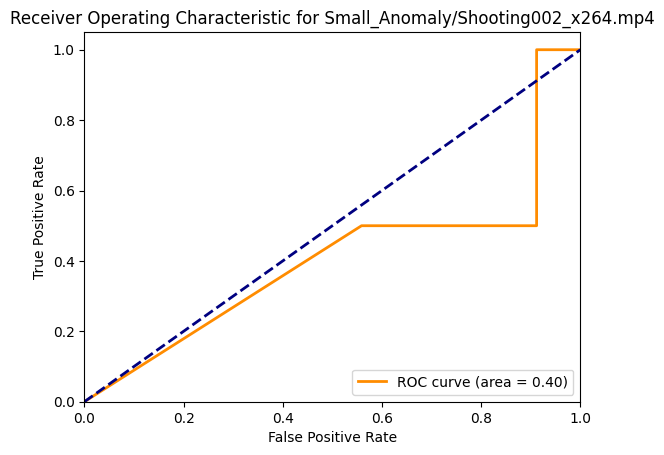

Evaluating: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos_603_x264.mp4
key Small_Normal/Normal_Videos_603_x264.mp4
video_type normal
1/1 [==============================] - 6s 6s/step


<ipython-input-15-130e0fff8542>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(model.predict(segment[np.newaxis, ...])[0])


segment_index is 0, segment_start_frame is 0, segment_end_frame is 32, raw prediction is 0.0771, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 1, segment_start_frame is 32, segment_end_frame is 64, raw prediction is 0.0848, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 2, segment_start_frame is 64, segment_end_frame is 96, raw prediction is 0.0937, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 3, segment_start_frame is 96, segment_end_frame is 128, raw prediction is 0.1358, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 6s 6s/step
segment_index is 4, segment_start_frame is 128, segment_end_frame is 160, raw prediction is 0.6018, predicted as anomalous? 1, groun

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Read video paths from the file
video_paths = read_video_paths_from_file(test_file_path,base_dataset_dir)
# Use "Shooting" and "Normal" to distinguish the types
# Extract the actual path from the annotation line, if not already a clean path
clean_video_paths = [path.split()[0] for path in video_paths]
annotation_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'
annotations = load_annotations_from_txt(annotation_path)
# `clean_video_path` is a list of video paths, `annotations` is your annotations dictionary, and `model` is your trained model
avg_scores = evaluate_model(model, clean_video_paths, annotations, base_dataset_dir)
print("Average scores for anomalous videos:", avg_scores['anomalous'])
print("Average scores for normal videos:", avg_scores['normal'])




# Categories for the x-axis
categories = ['Precision', 'Recall', 'F1 Score','AUC']


# Plotting
plt.figure(figsize=(8, 5))
plt.bar(categories, avg_scores, color=['blue', 'green', 'red'])

plt.title('Average Model Performance Scores')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1

# Display the actual score above each bar for clarity
for i, score in enumerate(avg_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')

plt.show()


print("Average AUC for anomalous videos:", avg_scores['anomalous']['auc'])
print("Average AUC for normal videos:", avg_scores['normal']['auc'])

# Visualize these AUC scores with a simple bar chart
labels = ['Anomalous Videos', 'Normal Videos']
auc_scores = [avg_scores['anomalous']['auc'], avg_scores['normal']['auc']]

plt.bar(labels, auc_scores, color=['red', 'blue'])
plt.ylabel('Average AUC')
plt.title('Average AUC Scores by Video Type')
plt.show()
